# Continuous Control

---

Congratulations for completing the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program!  In this notebook, you will learn how to control an agent in a more challenging environment, where the goal is to train a creature with four arms to walk forward.  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Crawler.app"`
- **Windows** (x86): `"path/to/Crawler_Windows_x86/Crawler.exe"`
- **Windows** (x86_64): `"path/to/Crawler_Windows_x86_64/Crawler.exe"`
- **Linux** (x86): `"path/to/Crawler_Linux/Crawler.x86"`
- **Linux** (x86_64): `"path/to/Crawler_Linux/Crawler.x86_64"`
- **Linux** (x86, headless): `"path/to/Crawler_Linux_NoVis/Crawler.x86"`
- **Linux** (x86_64, headless): `"path/to/Crawler_Linux_NoVis/Crawler.x86_64"`

For instance, if you are using a Mac, then you downloaded `Crawler.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Crawler.app")
```

In [2]:
env = UnityEnvironment(file_name='./Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.30408478e+00 -1.00000000e+00
 -4.92529202e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -5.33014059e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [7]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

NameError: name 'num_agents' is not defined

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Simple Reinforce Algorithm

Here a simple reinforce algorithm is trained to solve the reacher problem. Even after 800 episodes there is only litte progress. The high variance of this monte carlo approach leads to a very slow rate of convergence.

In [ ]:
from pi_network import PiNetwork
from reinforce import reinforce
device='cpu'
policy = PiNetwork().to(device)


In [ ]:
policy, scores = reinforce(policy, env, brain_name, n_episodes=100)

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    #actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    actions,_ = policy.act(states)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                        # get reward (for each agent)
    print(rewards)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

### Actor Critic

A deep deterministic policy gradient (DDPG) actor critic method is trained. For training a replay buffer of size 100000 with a batch size of 128 is used. The policy (actor) network consists of two hidden layers with 64 neurons with relu activation and tanh as activation in the output layer. The Q-network (critic) also consists of two hidden layers with 128 and 64 neurons and relu activation.

In order to control the eploration of the agent an Ornstein-Uhlenbeck process is used. The parameters are as follows 
   - $\theta = 0.05$ (mean reversion rate)
   - $\mu = 0.0$ (mean)
   - $\sigma = 0.2$ (standard deviation)
    
Sigma decays over the number of episodes with a factor of $\sigma_{decay}=0.995$ until it reaches its minimum $\sigma_{min}=0.01$.

- $\gamma$: Discount factor during the computation of the target $(target = reward + gamma*Qvalue(state_{t+1}, action_{t+1})$.
- $\tau$, update_every: $\tau$ is a float value used to compute the convex combination of old Q-network's and target Q-network's weights. The weights are updated every update_every steps to stabilize the learning process.
- $lr$: Learning rates for the optimizer of the Q-network and the Policy network.


During each training step the Q-network is optimized by minimizing the mean squared error of the temporal difference $ reward + gamma*Qvalue(state_{t+1}, action_{t+1}) - Qvalue(state_t, action_t)$. Thus learning to estimate the value of a certain action in a certain state. The policy network is then optimized to choose actions with a high value via optimizing the policy network weights to maximize $Q(state, policy(state))$.
   
The replay buffer breaks the correlation between samples in a consecutive episode and therefore stabilizes the learning process.

In [4]:
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-4              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic

In [9]:
from pi_network import PiNetwork
from q_network import QNetwork

actor = PiNetwork(input_size=state_size, output_size=action_size, lr=LR_ACTOR)
critic = QNetwork(input_size=state_size+action_size, lr=LR_CRITIC)

In [10]:
from agent import ActorCriticAgent
from ounoise import OUNoise
from replay_buffer import ReplayBuffer
from trainer import Trainer

batch_size = 128

memory = ReplayBuffer(state_size, BUFFER_SIZE , BATCH_SIZE, 1337)
noise = OUNoise(action_size, num_agents, 1337, sigma_decay=0.995, sigma_min=0.01)
ac = ActorCriticAgent(gamma=GAMMA, tau=TAU, batch_size=BATCH_SIZE, update_every=1,
                      actor=actor, critic=critic, memory=memory, ou_noise=noise)


In [11]:
trainer = Trainer(env, ac)

In [12]:
scores = trainer.train(800)

E:\github\pg_continuous_control\agent.py:116: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 0	Average Score: 0.08,   0.08
Episode 100	Average Score: 3.49,   4.62
Episode 200	Average Score: 9.00,   11.27
Episode 300	Average Score: 18.24,   10.22
Episode 395	Average Score: 35.87,   37.91
Problem solved after 396 episodes


Text(0.5, 1.0, 'Score: Reacher environment')

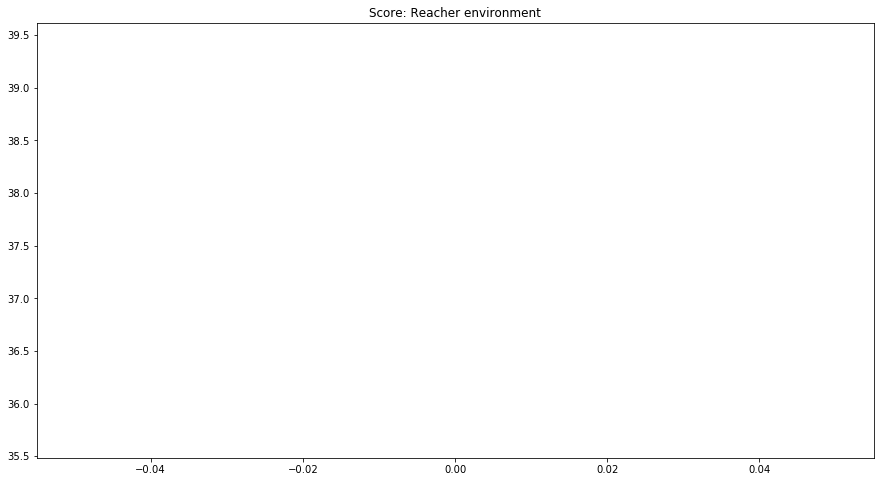

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,8))
plt.plot(scores)
plt.title('Score: Reacher environment')

In [24]:
import torch
path = './policy_network_reacher'
#actor = trainer.agent.actor_local.state_dict()
#torch.save(trainer.agent.actor_local.state_dict(), path)
actor = PiNetwork(input_size=state_size, output_size=action_size, lr=LR_ACTOR)
actor.load_state_dict(torch.load(path))
actor.eval()

PiNetwork(
  (model): Sequential(
    (fc1): Linear(in_features=33, out_features=64, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (relu2): ReLU()
    (logits): Linear(in_features=64, out_features=4, bias=True)
    (tanh): Tanh()
  )
)

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(1)                                   # initialize the score (for each agent)
while True:
    actions = actor(torch.from_numpy(states).float()).cpu().data.numpy()
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))